## CNN approach

### The Plan:

### Feature Extraction Step:

* For each of the subjects' .nii.gz files, we will first need to extract the ROI time-series using a standard brain atlas (cc400)
* From these time-series, we will compute the 2D correlation matrix (the FC matrix) for each subject.


### Modeling Step:

* We will treat the FC Matrix as an Image of size (392, 392)

* Adapt the 2D CNN to the new features. Instead of feeding it slices of a 3D brain, we will feed it our 2D FC matrices.

The 2D CNN is perfectly suited to find spatial patterns in these matrices.

In [1]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 86.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Libraries imported and TensorFlow version:", tf.__version__)

Libraries imported and TensorFlow version: 2.19.0


In [ ]:
import os
import numpy as np
import pandas as pd
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from tqdm import tqdm

# --- 1. Input and Output Paths ---


def extract_and_save_fc_matrices():
    nifti_base_path = '/content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset/func_preproc_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/func_preproc'
    pheno_file_path = '/content/drive/MyDrive/ASD-project/data/ABIDE_Project/Phenotypic_V1_0b_preprocessed1 (2).csv'
    output_fc_dir = '/content/drive/MyDrive/ASD-project/data/ABIDE_Project/fc_matrices_cc400_pearson'

    # --- 2. Path to local atlas file ---
    atlas_path = '/content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset/atlases/CC400.nii'

    print("--- Feature Extraction Started ---")

    os.makedirs(output_fc_dir, exist_ok=True)
    print(f"Output directory created at: {output_fc_dir}")

    # --- 3. Get List of Subjects from Phenotype File ---
    try:
        pheno_df = pd.read_csv(pheno_file_path)
        pheno_df = pheno_df[pheno_df['FILE_ID'] != 'no_filename']
        subject_ids = pheno_df['FILE_ID'].tolist()
        print(f"Found {len(subject_ids)} subjects in the phenotype file.")
    except FileNotFoundError:
        print(f"Error: Phenotype file not found at {pheno_file_path}")
        return

    # --- 4. Set up Nilearn Components with the local CC400 Atlas ---
    print("Using local CC400 atlas from Drive...")

    if not os.path.exists(atlas_path):
        print(f"Error: CC400 atlas file not found at {atlas_path}. Please check the path.")
        return

    # masker object to extract time-series
    masker = NiftiLabelsMasker(
        labels_img=atlas_path,
        standardize=True, # Z-score standardization
        memory='nilearn_cache',
        verbose=0
    )

    # Use Pearson correlation as the connectivity measure
    correlation_measure = ConnectivityMeasure(
        kind='correlation',
        vectorize=False
    )

    # --- 5. Loop Through Subjects and Process Files ---
    print(f"\nProcessing {len(subject_ids)} files. This may take a while...")

    success_count = 0
    error_count = 0

    for subject_id in tqdm(subject_ids, desc="Calculating FC Matrices"):
        fmri_file_path = os.path.join(nifti_base_path, f"{subject_id}_func_preproc.nii.gz")
        output_npy_path = os.path.join(output_fc_dir, f"{subject_id}.npy")

        if os.path.exists(output_npy_path):
            success_count += 1
            continue

        if not os.path.exists(fmri_file_path):
            error_count += 1
            continue

        try:
            # Step 5a: Extract time-series
            time_series = masker.fit_transform(fmri_file_path)

            # Step 5b: Compute functional connectivity matrix
            fc_matrix = correlation_measure.fit_transform([time_series])[0]

            # Fill diagonal with 0s as in the original notebook
            np.fill_diagonal(fc_matrix, 0)

            # Step 5c: Save the resulting matrix
            np.save(output_npy_path, fc_matrix)
            success_count += 1

        except Exception as e:
            print(f"\nError processing {subject_id}: {e}")
            error_count += 1

    print("\n--- Feature Extraction Complete ---")
    print(f"Successfully processed and saved: {success_count} files.")
    print(f"Skipped or errored: {error_count} files.")


if __name__ == "__main__":
    extract_and_save_fc_matrices()

--- Feature Extraction Started ---
Output directory created at: /content/drive/MyDrive/ASD-project/data/ABIDE_Project/fc_matrices_cc400_pearson
Found 1035 subjects in the phenotype file.
Using local CC400 atlas from Drive...

Processing 1035 files. This may take a while...


Calculating FC Matrices: 100%|██████████| 1035/1035 [3:58:24<00:00, 13.82s/it]


--- Feature Extraction Complete ---
Successfully processed and saved: 884 files.
Skipped or errored: 151 files.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- 1. Load Data: FC Matrices and Labels ---

fc_matrix_dir = '/content/drive/MyDrive/ASD-project/data/ABIDE_Project/fc_matrices_cc400_pearson'
pheno_file_path = '/content/drive/MyDrive/ASD-project/data/ABIDE_Project/Phenotypic_V1_0b_preprocessed1 (2).csv'


pheno_df = pd.read_csv(pheno_file_path)
pheno_df = pheno_df[pheno_df['FILE_ID'] != 'no_filename']
pheno_df['label'] = pheno_df['DX_GROUP'].apply(lambda x: 1 if x == 1 else 0)
print("Phenotype file loaded.")


X, y = [], []
all_fc_files = os.listdir(fc_matrix_dir)
for filename in tqdm(all_fc_files, desc="Loading FC Matrices"):
    if filename.endswith('.npy'):
        subject_id = filename.replace('.npy', '')
        pheno_row = pheno_df[pheno_df['FILE_ID'] == subject_id]
        if not pheno_row.empty:
            label = pheno_row.iloc[0]['label']
            fc_matrix = np.load(os.path.join(fc_matrix_dir, filename))

            np.nan_to_num(fc_matrix, copy=False)

            X.append(fc_matrix)
            y.append(label)

X = np.array(X)
y = np.array(y)
print(f"\nSuccessfully loaded {len(X)} FC matrices. Data shape: {X.shape}")

Phenotype file loaded.


Loading FC Matrices: 100%|██████████| 885/885 [01:19<00:00, 11.12it/s]



Successfully loaded 884 FC matrices. Data shape: (884, 392, 392)


In [ ]:
# --- 2. Balance the Dataset with SMOTE ---
X_reshaped = X.reshape((X.shape[0], -1))
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_reshaped, y)


X_resampled = X_resampled.reshape((-1, X.shape[1], X.shape[2]))
print(f"Data shape after SMOTE: {X_resampled.shape}")

Data shape after SMOTE: (952, 392, 392)


### Developing the CNN model

In [64]:
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization,
    MaxPooling2D, SpatialDropout2D, GlobalAveragePooling2D, Dense, Dropout,LayerNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [118]:
def cnn_for_fc(input_shape, num_classes=2):
    inputs = Input(shape=input_shape)

    # Block 1: Fewer filters and larger kernel
    x = Conv2D(16, kernel_size=5, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    # Block 2: Still a moderate number of filters
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    # Flatten and Dense layers for classification
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# --- 4. K-Fold Cross-Validation and Training ---

def data_generator(data, labels, batch_size):
    dataset_size = len(data)
    indices = np.arange(dataset_size)
    np.random.shuffle(indices)
    def generator():
        while True:
            for start_idx in range(0, dataset_size, batch_size):
                batch_indices = indices[start_idx:start_idx + batch_size]
                if len(batch_indices) < batch_size: continue

                X_batch = data[batch_indices]
                y_batch = labels[batch_indices]

                # Add the channel dimension for the CNN
                yield X_batch[..., np.newaxis], to_categorical(y_batch, num_classes=2)
    return generator

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import numpy as np
import scipy.stats as st
from tensorflow.keras.utils import to_categorical

# --- Setup for Training ---
input_shape = (X_resampled.shape[1], X_resampled.shape[2], 1)
batch_size = 16
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
histories = []
fold_results = []   # to collect (acc, auc) per fold
roc_data = [] # To store fpr, tpr, and auc for each fold

print("\n--- Starting K-Fold Cross-Validation Training ---")

for train_index, val_index in kfold.split(X_resampled):
    print(f'\n--- Training Fold {fold_no} ---')
    X_train, X_val = X_resampled[train_index], X_resampled[val_index]
    y_train, y_val = y_resampled[train_index], y_resampled[val_index]

    train_gen = data_generator(X_train, y_train, batch_size)
    val_gen = data_generator(X_val, y_val, batch_size)

    train_dataset = tf.data.Dataset.from_generator(train_gen, output_signature=(
        tf.TensorSpec(shape=(None, *input_shape), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )).prefetch(tf.data.AUTOTUNE) 
    val_dataset = tf.data.Dataset.from_generator(val_gen, output_signature=(
        tf.TensorSpec(shape=(None, *input_shape), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )).prefetch(tf.data.AUTOTUNE) 


    model = cnn_for_fc(input_shape)
    if fold_no == 1: model.summary()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    history = model.fit(
        train_dataset,
        epochs=100,
        validation_data=val_dataset,
        steps_per_epoch=len(X_train) // batch_size,
        validation_steps=len(X_val) // batch_size,
        callbacks=[early_stopping, lr_scheduler],
        verbose=2
    )
    histories.append(history)
    model.save(f"fold_{fold_no}_best.h5")


    y_val_pred = model.predict(X_val, batch_size=batch_size)


    y_val_true_one_hot = to_categorical(y_val, num_classes=2)



    acc = accuracy_score(y_val_true_one_hot.argmax(axis=1), y_val_pred.argmax(axis=1))

    auc = roc_auc_score(y_val_true_one_hot[:, 1], y_val_pred[:, 1])

 
    fpr, tpr, thresholds = roc_curve(y_val_true_one_hot[:, 1], y_val_pred[:, 1])
    roc_data.append((fpr, tpr, auc))


    print(f"Fold {fold_no} -- Val Accuracy: {acc:.3f}, Val AUC: {auc:.3f}")
    fold_results.append((acc, auc))

    fold_no += 1

print("\n--- Training Complete ---")


--- Starting K-Fold Cross-Validation Training ---

--- Training Fold 1 ---


Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_67 (InputLayer)     │ (None, 392, 392, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_144 (Conv2D)             │ (None, 392, 392, 16)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 392, 392, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_142               │ (None, 196, 196, 16)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_151 (Dropout)           │ (None, 196, 196, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_145 (Conv2D)             │ (None, 196, 196, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 196, 196, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_143               │ (None, 98, 98, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_152 (Dropout)           │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_43 (Flatten)            │ (None, 307328)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 128)            │    39,338,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_153 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,343,618 (150.08 MB)

 Trainable params: 39,343,522 (150.08 MB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/100
47/47 - 7s - 151ms/step - accuracy: 0.5279 - loss: 3.7552 - val_accuracy: 0.4205 - val_loss: 0.9564 - learning_rate: 1.0000e-04
Epoch 2/100
47/47 - 1s - 14ms/step - accuracy: 0.5319 - loss: 0.6977 - val_accuracy: 0.4602 - val_loss: 1.2021 - learning_rate: 1.0000e-04
Epoch 3/100
47/47 - 1s - 14ms/step - accuracy: 0.5359 - loss: 0.6943 - val_accuracy: 0.4489 - val_loss: 4.2554 - learning_rate: 1.0000e-04
Epoch 4/100
47/47 - 1s - 14ms/step - accuracy: 0.5492 - loss: 0.6803 - val_accuracy: 0.4489 - val_loss: 12.3582 - learning_rate: 1.0000e-04
Epoch 5/100
47/47 - 1s - 14ms/step - accuracy: 0.5612 - loss: 0.6834 - val_accuracy: 0.4489 - val_loss: 8.7987 - learning_rate: 1.0000e-04
Epoch 6/100

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
47/47 - 1s - 14ms/step - accuracy: 0.5705 - loss: 0.6799 - val_accuracy: 0.4375 - val_loss: 4.5908 - learning_rate: 1.0000e-04
Epoch 7/100
47/47 - 1s - 14ms/step - accuracy: 0.5545 - loss: 0.6835 - val_accuracy: 0.

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Fold 1 -- Val Accuracy: 0.723, Val AUC: 0.811

--- Training Fold 2 ---
Epoch 1/100
47/47 - 7s - 150ms/step - accuracy: 0.4907 - loss: 3.9332 - val_accuracy: 0.4261 - val_loss: 17.2839 - learning_rate: 1.0000e-04
Epoch 2/100
47/47 - 1s - 14ms/step - accuracy: 0.5239 - loss: 0.6954 - val_accuracy: 0.4261 - val_loss: 40.0241 - learning_rate: 1.0000e-04
Epoch 3/100
47/47 - 1s - 14ms/step - accuracy: 0.5545 - loss: 0.7041 - val_accuracy: 0.4261 - val_loss: 51.8037 - learning_rate: 1.0000e-04
Epoch 4/100
47/47 - 1s - 15ms/step - accuracy: 0.5691 - loss: 0.6702 - val_accuracy: 0.4261 - val_loss: 58.7259 - learning_rate: 1.0000e-04
Epoch 5/100
47/47 - 1s - 14ms/step - accuracy: 0.6037 - loss: 0.6468 - val_accuracy: 0.4261 - val_loss: 60.1046 - learning_rate: 1.0000e-04
Epoch 6/100

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
47/47 - 1s - 15ms/step - accuracy: 0.6250 - loss: 0.6088 - val_accuracy: 0.4261 - val_loss: 56.0787

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Fold 2 -- Val Accuracy: 0.770, Val AUC: 0.816

--- Training Fold 3 ---
Epoch 1/100
47/47 - 7s - 147ms/step - accuracy: 0.5386 - loss: 7.6067 - val_accuracy: 0.4716 - val_loss: 27.9751 - learning_rate: 1.0000e-04
Epoch 2/100
47/47 - 1s - 14ms/step - accuracy: 0.5505 - loss: 0.9460 - val_accuracy: 0.4716 - val_loss: 61.7162 - learning_rate: 1.0000e-04
Epoch 3/100
47/47 - 1s - 14ms/step - accuracy: 0.5824 - loss: 0.7111 - val_accuracy: 0.4716 - val_loss: 88.3397 - learning_rate: 1.0000e-04
Epoch 4/100
47/47 - 1s - 14ms/step - accuracy: 0.6383 - loss: 0.6410 - val_accuracy: 0.4716 - val_loss: 118.4844 - learning_rate: 1.0000e-04
Epoch 5/100
47/47 - 1s - 14ms/step - accuracy: 0.6556 - loss: 0.5879 - val_accuracy: 0.4716 - val_loss: 123.5030 - learning_rate: 1.0000e-04
Epoch 6/100

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
47/47 - 1s - 14ms/step - accuracy: 0.7128 - loss: 0.5627 - val_accuracy: 0.4716 - val_loss: 118.6

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Fold 3 -- Val Accuracy: 0.695, Val AUC: 0.766

--- Training Fold 4 ---
Epoch 1/100
47/47 - 7s - 146ms/step - accuracy: 0.4428 - loss: 4.9688 - val_accuracy: 0.4659 - val_loss: 4.7174 - learning_rate: 1.0000e-04
Epoch 2/100
47/47 - 1s - 15ms/step - accuracy: 0.5439 - loss: 0.6901 - val_accuracy: 0.4659 - val_loss: 10.6185 - learning_rate: 1.0000e-04
Epoch 3/100
47/47 - 1s - 14ms/step - accuracy: 0.5160 - loss: 0.6954 - val_accuracy: 0.4659 - val_loss: 15.5851 - learning_rate: 1.0000e-04
Epoch 4/100
47/47 - 1s - 14ms/step - accuracy: 0.5146 - loss: 0.6884 - val_accuracy: 0.4659 - val_loss: 18.2020 - learning_rate: 1.0000e-04
Epoch 5/100
47/47 - 1s - 14ms/step - accuracy: 0.5612 - loss: 0.6857 - val_accuracy: 0.4659 - val_loss: 18.8568 - learning_rate: 1.0000e-04
Epoch 6/100

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
47/47 - 1s - 14ms/step - accuracy: 0.5745 - loss: 0.6668 - val_accuracy: 0.4659 - val_loss: 18.2833 

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Fold 4 -- Val Accuracy: 0.732, Val AUC: 0.774

--- Training Fold 5 ---
Epoch 1/100
47/47 - 7s - 143ms/step - accuracy: 0.4973 - loss: 3.9405 - val_accuracy: 0.5568 - val_loss: 4.3679 - learning_rate: 1.0000e-04
Epoch 2/100
47/47 - 1s - 14ms/step - accuracy: 0.5465 - loss: 0.6837 - val_accuracy: 0.5568 - val_loss: 7.5956 - learning_rate: 1.0000e-04
Epoch 3/100
47/47 - 1s - 14ms/step - accuracy: 0.5638 - loss: 0.6812 - val_accuracy: 0.5568 - val_loss: 12.4796 - learning_rate: 1.0000e-04
Epoch 4/100
47/47 - 1s - 14ms/step - accuracy: 0.5798 - loss: 0.7048 - val_accuracy: 0.5568 - val_loss: 16.5899 - learning_rate: 1.0000e-04
Epoch 5/100
47/47 - 1s - 14ms/step - accuracy: 0.5864 - loss: 0.6553 - val_accuracy: 0.5568 - val_loss: 17.4672 - learning_rate: 1.0000e-04
Epoch 6/100

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
47/47 - 1s - 14ms/step - accuracy: 0.6263 - loss: 0.6377 - val_accuracy: 0.5568 - val_loss: 17.4369 -

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Fold 5 -- Val Accuracy: 0.647, Val AUC: 0.736

--- Training Complete ---


In [121]:
results = np.array(fold_results)  # shape (n_folds, 2)
accs, aucs = results[:,0], results[:,1]

def ci95(data):
    mean = np.mean(data)
    sem = st.sem(data)  # standard error
    ci = st.t.interval(0.95, len(data)-1, loc=mean, scale=sem)
    return mean, np.std(data), ci

mean_acc, std_acc, ci_acc = ci95(accs)
mean_auc, std_auc, ci_auc = ci95(aucs)

print("\n--- Cross-Fold Results ---")
print(f"Accuracy: {mean_acc:.3f} ± {std_acc:.3f} "
      f"(95% CI {ci_acc[0]:.3f} – {ci_acc[1]:.3f})")
print(f"AUC:      {mean_auc:.3f} ± {std_auc:.3f} "
      f"(95% CI {ci_auc[0]:.3f} – {ci_auc[1]:.3f})")


--- Cross-Fold Results ---
Accuracy: 0.713 ± 0.041 (95% CI 0.657 – 0.770)
AUC:      0.781 ± 0.030 (95% CI 0.740 – 0.822)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

all_metrics = []
all_confusion_matrices = []
fold_no = 1

for train_index, val_index in kfold.split(X_resampled):
    X_val = X_resampled[val_index]
    y_val = y_resampled[val_index]

    history_fold = histories[fold_no - 1]
    best_epoch = np.argmin(history_fold.history['val_loss']) + 1


    val_accuracy_at_best_epoch = history_fold.history['val_accuracy'][best_epoch - 1]

    all_metrics.append({
        'Fold': fold_no,
        'Best Epoch': best_epoch,
        'Validation Accuracy': val_accuracy_at_best_epoch,
        'Final Training Accuracy': history_fold.history['accuracy'][-1],
    })

    print(f"Analysis for Fold {fold_no}: Best validation accuracy was {val_accuracy_at_best_epoch:.4f} at epoch {best_epoch}")
    fold_no += 1

Analysis for Fold 1: Best validation accuracy was 0.7216 at epoch 85
Analysis for Fold 2: Best validation accuracy was 0.7614 at epoch 19
Analysis for Fold 3: Best validation accuracy was 0.6875 at epoch 18
Analysis for Fold 4: Best validation accuracy was 0.7102 at epoch 53
Analysis for Fold 5: Best validation accuracy was 0.6364 at epoch 42



--- Model Performance Across Folds (from History) ---
 Fold  Best Epoch  Validation Accuracy  Final Training Accuracy
    1          85             0.721591                 0.952128
    2          19             0.761364                 0.796543
    3          18             0.687500                 0.957447
    4          53             0.710227                 0.789894
    5          42             0.636364                 0.828457


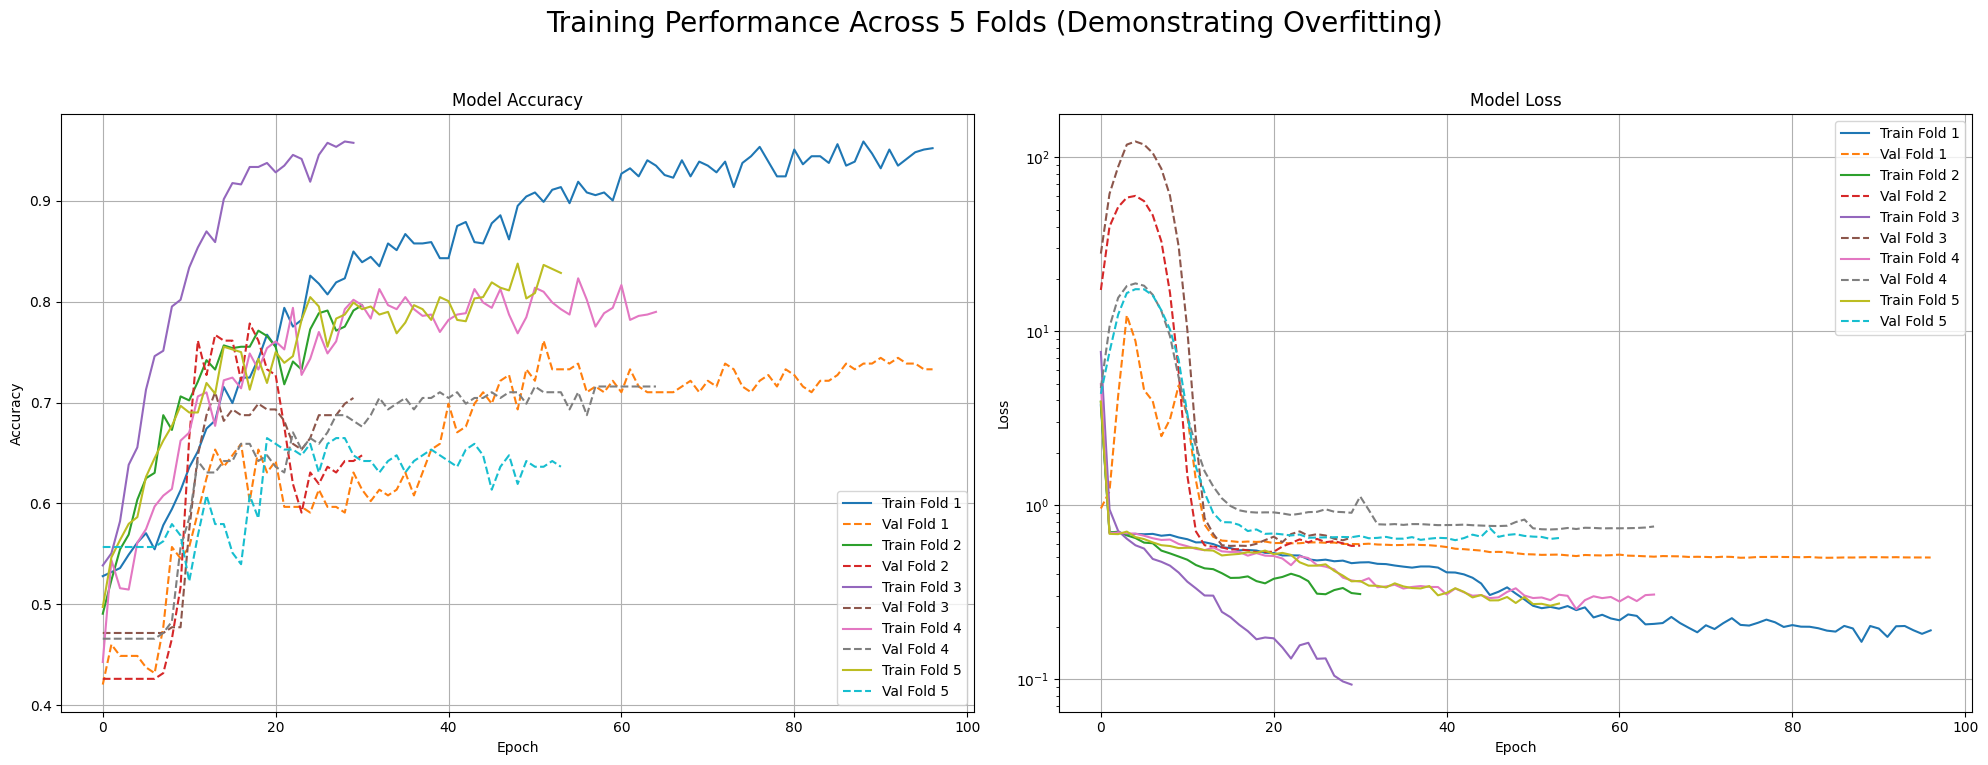

In [123]:
# --- Performance Table ---
metrics_df = pd.DataFrame(all_metrics)
print("\n--- Model Performance Across Folds (from History) ---")
print(metrics_df.to_string(index=False))

# --- Training History for All Folds ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Training Performance Across 5 Folds (Demonstrating Overfitting)', fontsize=20)

# Accuracy Plot
axes[0].set_title('Model Accuracy')
for i, history in enumerate(histories):
    axes[0].plot(history.history['accuracy'], label=f'Train Fold {i+1}')
    axes[0].plot(history.history['val_accuracy'], label=f'Val Fold {i+1}', linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss Plot
axes[1].set_title('Model Loss')
for i, history in enumerate(histories):
    axes[1].plot(history.history['loss'], label=f'Train Fold {i+1}')
    axes[1].plot(history.history['val_loss'], label=f'Val Fold {i+1}', linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [124]:
from tensorflow.keras.models import load_model

In [125]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# --- Utilities ---
def ensure_one_hot(y, num_classes=2):
    """Accepts integer labels (N,) or one-hot (N,C). Returns one-hot (N,C)."""
    y = np.asarray(y)
    if y.ndim == 1:
        return to_categorical(y, num_classes=num_classes)
    if y.ndim == 2 and y.shape[1] == num_classes:
        return y
    raise ValueError(f"Unexpected y shape {y.shape}. Provide ints or one-hot with C={num_classes}.")

def expected_calibration_error(y_true_onehot, y_pred_probs, n_bins=15):
    """ECE with equal-width bins over confidence."""
    y_true = np.argmax(y_true_onehot, axis=1)
    confidences = np.max(y_pred_probs, axis=1)
    predictions = np.argmax(y_pred_probs, axis=1)
    accuracies = (predictions == y_true).astype(float)

    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    bin_accs, bin_confs, bin_fracs = [], [], []

    for i in range(n_bins):
        in_bin = (confidences > bins[i]) & (confidences <= bins[i+1])
        prop = np.mean(in_bin) if np.any(in_bin) else 0.0
        if prop > 0:
            bin_conf = np.mean(confidences[in_bin])
            bin_acc  = np.mean(accuracies[in_bin])
            ece += np.abs(bin_acc - bin_conf) * prop
            bin_accs.append(bin_acc); bin_confs.append(bin_conf); bin_fracs.append(prop)
        else:
            bin_accs.append(np.nan); bin_confs.append((bins[i]+bins[i+1])/2); bin_fracs.append(0.0)
    return ece, (bins, np.array(bin_accs), np.array(bin_confs), np.array(bin_fracs))

def plot_reliability_diagram(bins, bin_accs, bin_confs, title="Reliability diagram"):
    mask = ~np.isnan(bin_accs)
    plt.figure(figsize=(5.5,5.5))
    plt.plot([0,1],[0,1],'--',lw=1)
    plt.scatter(bin_confs[mask], bin_accs[mask], s=35)
    plt.xlabel("Predicted confidence")
    plt.ylabel("Empirical accuracy")
    plt.title(title)
    plt.xlim(0,1); plt.ylim(0,1)
    plt.grid(True, alpha=0.3)
    plt.show()

# --- Temperature scaling wrapper ---
class TemperatureScaled(tf.keras.Model):
    """
    Wraps a softmax-probability model. Applies temperature on *logits* approximated by log probs.
    Works well for calibration; base model remains frozen.
    """
    def __init__(self, base_model, init_temp=1.0):
        super().__init__()
        self.base = base_model
        self.log_temp = tf.Variable(tf.math.log(init_temp), trainable=True, dtype=tf.float32)

    def call(self, x, training=False):
        # Base model expected to output softmax probs of shape (N, C)
        p = self.base(x, training=False)
        p = tf.clip_by_value(p, 1e-7, 1.0)
        log_p = tf.math.log(p)                 # pseudo-logits
        scaled = log_p / tf.exp(self.log_temp) # divide by T
        return tf.nn.softmax(scaled, axis=-1)

def fit_temperature(base_model, X_cal, y_cal, lr=0.02, steps=600, verbose=True):
    """
    Optimize temperature to minimize NLL on calibration set.
    X_cal: array (N, H, W, 1)
    y_cal: ints (N,) or one-hot (N, C)
    """
    y_cal_oh = ensure_one_hot(y_cal, num_classes=2)
    ts_model = TemperatureScaled(base_model, init_temp=1.0)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    X_cal_tf = tf.convert_to_tensor(X_cal, dtype=tf.float32)
    y_cal_tf = tf.convert_to_tensor(y_cal_oh, dtype=tf.float32)

    for step in range(steps):
        with tf.GradientTape() as tape:
            probs = ts_model(X_cal_tf, training=False)
            # categorical_crossentropy expects one-hot vs probs
            loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_cal_tf, probs))
        grads = tape.gradient(loss, [ts_model.log_temp])
        opt.apply_gradients(zip(grads, [ts_model.log_temp]))
        if verbose and (step % 100 == 0 or step == steps-1):
            print(f"Step {step:03d} | Temp = {tf.exp(ts_model.log_temp).numpy():.3f} | NLL = {loss.numpy():.4f}")
    return ts_model


--- Analysis for Fold 1 ---
Step 000 | Temp = 0.980 | NLL = 0.0861
Step 100 | Temp = 0.311 | NLL = 0.0085
Step 200 | Temp = 0.222 | NLL = 0.0056
Step 300 | Temp = 0.178 | NLL = 0.0047
Step 400 | Temp = 0.146 | NLL = 0.0041
Step 500 | Temp = 0.119 | NLL = 0.0035
Step 599 | Temp = 0.096 | NLL = 0.0030
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
ECE (uncalibrated): 0.079
ECE (calibrated)  : 0.003


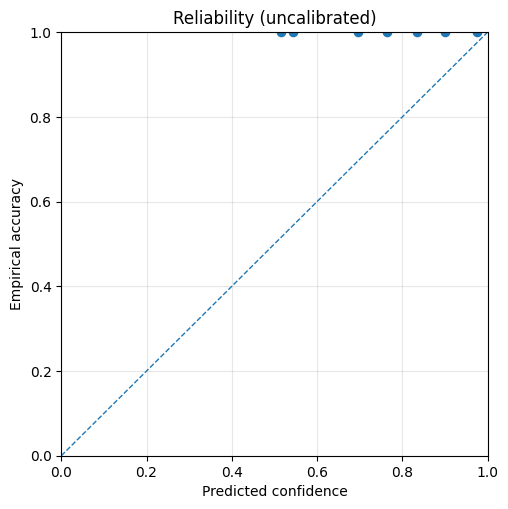

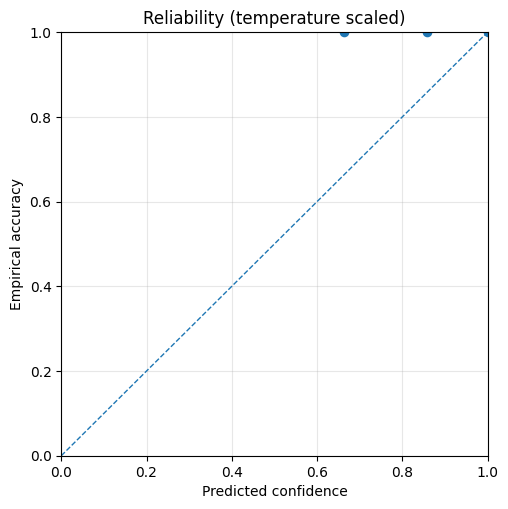


--- Analysis for Fold 2 ---
Step 000 | Temp = 0.980 | NLL = 0.2617
Step 100 | Temp = 0.235 | NLL = 0.0572
Step 200 | Temp = 0.164 | NLL = 0.0493
Step 300 | Temp = 0.151 | NLL = 0.0490
Step 400 | Temp = 0.149 | NLL = 0.0490
Step 500 | Temp = 0.149 | NLL = 0.0490
Step 599 | Temp = 0.149 | NLL = 0.0490
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
ECE (uncalibrated): 0.204
ECE (calibrated)  : 0.017


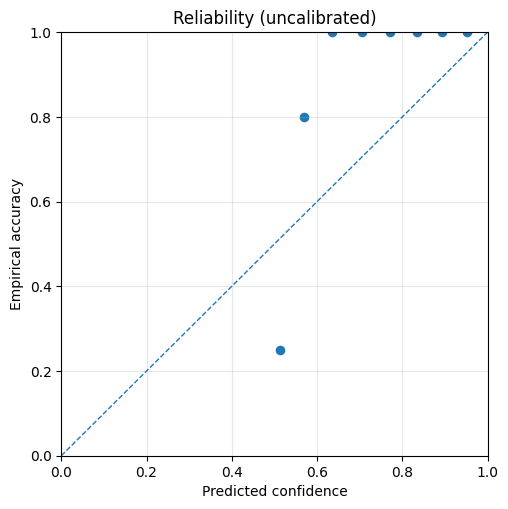

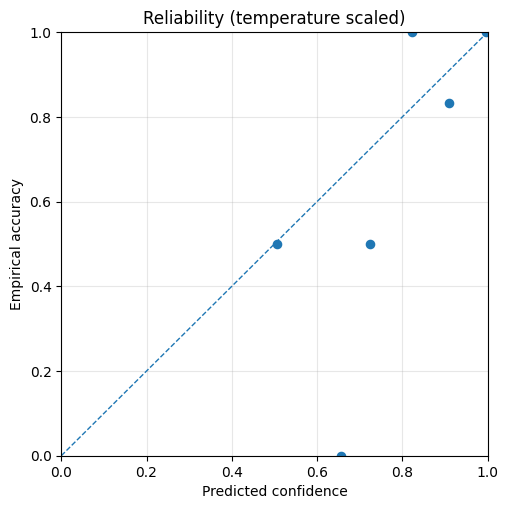


--- Analysis for Fold 3 ---
Step 000 | Temp = 0.980 | NLL = 0.1411
Step 100 | Temp = 0.284 | NLL = 0.0133
Step 200 | Temp = 0.200 | NLL = 0.0085
Step 300 | Temp = 0.162 | NLL = 0.0072
Step 400 | Temp = 0.137 | NLL = 0.0065
Step 500 | Temp = 0.118 | NLL = 0.0060
Step 599 | Temp = 0.103 | NLL = 0.0057
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
ECE (uncalibrated): 0.127
ECE (calibrated)  : 0.004


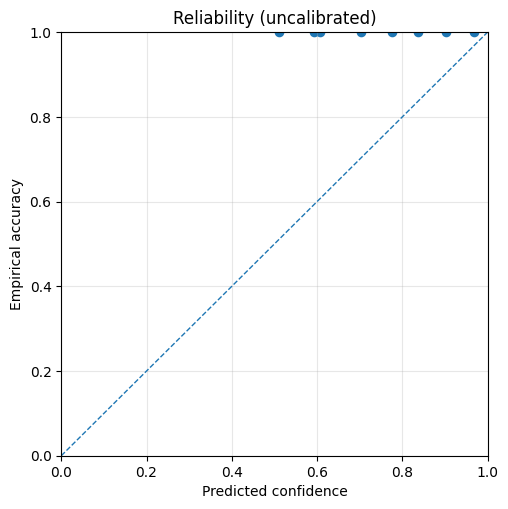

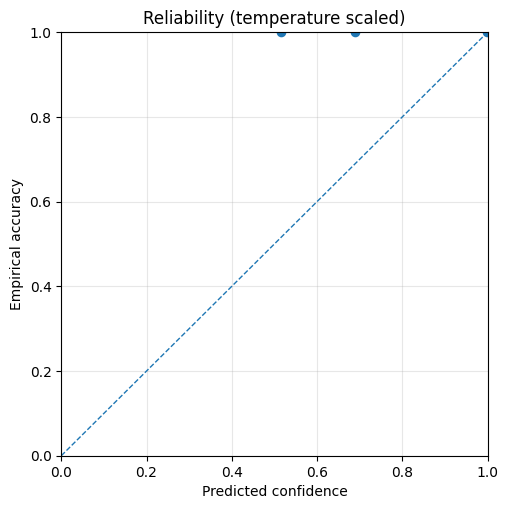


--- Analysis for Fold 4 ---
Step 000 | Temp = 0.980 | NLL = 0.3133
Step 100 | Temp = 0.394 | NLL = 0.2583
Step 200 | Temp = 0.391 | NLL = 0.2583
Step 300 | Temp = 0.391 | NLL = 0.2583
Step 400 | Temp = 0.391 | NLL = 0.2583
Step 500 | Temp = 0.391 | NLL = 0.2583
Step 599 | Temp = 0.391 | NLL = 0.2583
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
ECE (uncalibrated): 0.141
ECE (calibrated)  : 0.007


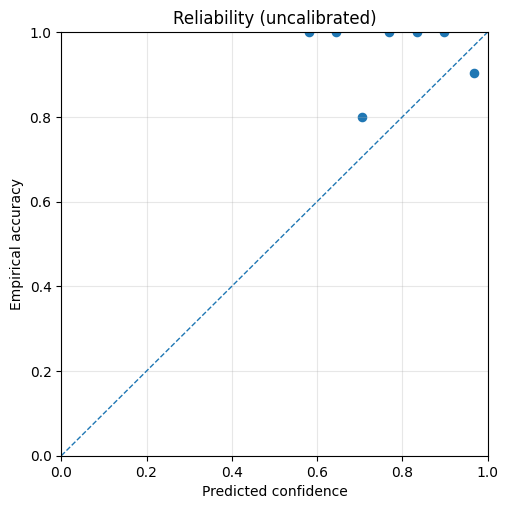

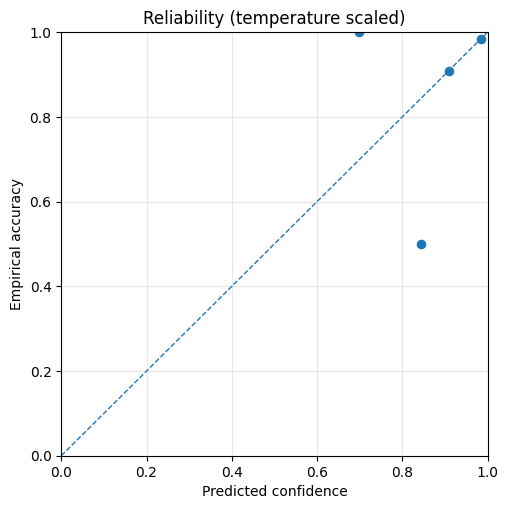


--- Analysis for Fold 5 ---
Step 000 | Temp = 1.020 | NLL = 0.6172
Step 100 | Temp = 1.413 | NLL = 0.6081
Step 200 | Temp = 1.411 | NLL = 0.6081
Step 300 | Temp = 1.411 | NLL = 0.6081
Step 400 | Temp = 1.411 | NLL = 0.6081
Step 500 | Temp = 1.411 | NLL = 0.6081
Step 599 | Temp = 1.411 | NLL = 0.6081
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
ECE (uncalibrated): 0.079
ECE (calibrated)  : 0.085


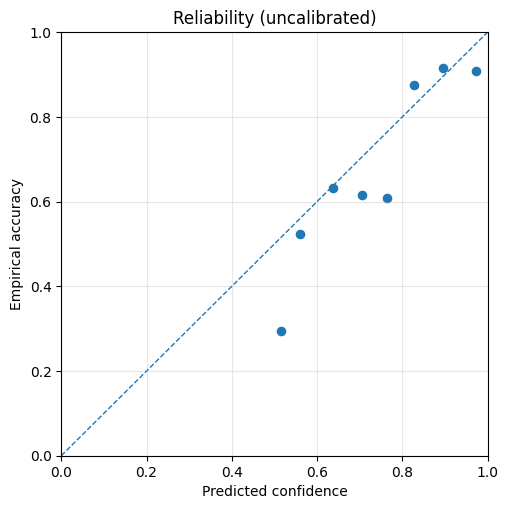

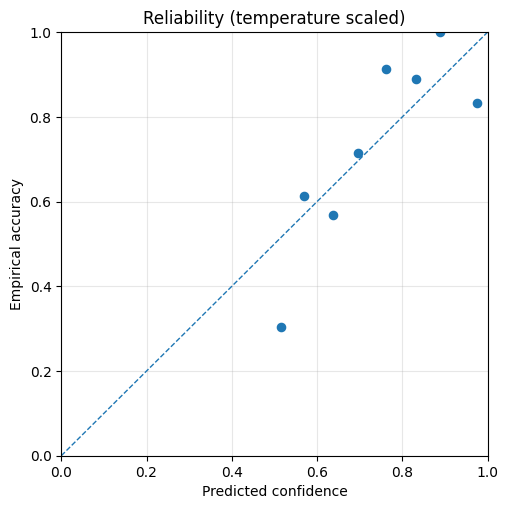

In [ ]:
from tensorflow.keras.models import load_model
for i in range(5):

    model = load_model(f"fold_{i+1}_best.h5")  
    print(f"\n--- Analysis for Fold {i+1} ---")


    ts_model = fit_temperature(model, X_val, y_val, lr=0.02, steps=600, verbose=True)


    y_val_oh = ensure_one_hot(y_val, num_classes=2)

    probs_uncal = model.predict(X_val, batch_size=32)
    probs_cal   = ts_model.predict(X_val, batch_size=32)

    # ECE
    ece_uncal, (bins, accs_u, confs_u, fracs_u) = expected_calibration_error(y_val_oh, probs_uncal, n_bins=15)
    ece_cal,   (bins, accs_c, confs_c, fracs_c) = expected_calibration_error(y_val_oh, probs_cal,   n_bins=15)
    print(f"ECE (uncalibrated): {ece_uncal:.3f}")
    print(f"ECE (calibrated)  : {ece_cal:.3f}")

    # Reliability diagrams
    plot_reliability_diagram(bins, accs_u, confs_u, title="Reliability (uncalibrated)")
    plot_reliability_diagram(bins, accs_c, confs_c, title="Reliability (temperature scaled)")

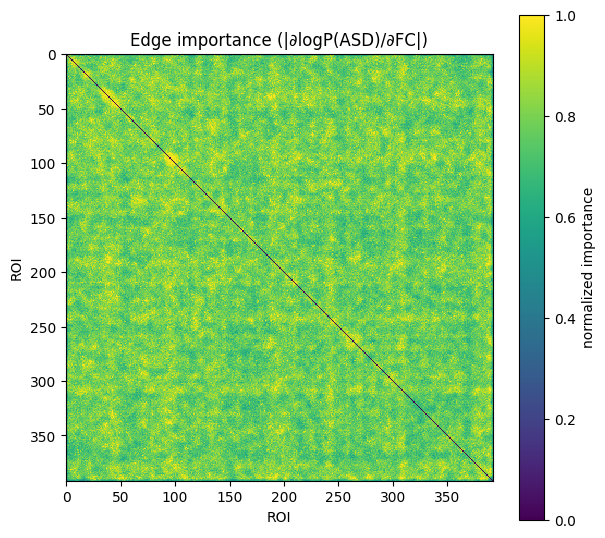

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

CLASS_IDX = 1       
BATCH_SIZE = 16
PERCENTILE_CLIP = 99.5 


def _ensure_4d(x):
    """Ensure (N, H, W, 1)."""
    x = np.asarray(x)
    if x.ndim == 3:
        x = x[..., np.newaxis]
    return x

@tf.function
def _batch_gradients(model, xb, class_idx=CLASS_IDX):
    """
    Returns gradients of log-probability of target class wrt inputs.
    More stable than raw probability.
    """
    xb = tf.cast(xb, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(xb)
        probs = model(xb, training=False)                # (B, 2)
        probs = tf.clip_by_value(probs, 1e-7, 1.0)
        logp  = tf.math.log(probs[:, class_idx])         # (B,)
    grads = tape.gradient(logp, xb)                      # (B, H, W, 1)
    return grads

def compute_mean_importance(model, X, batch_size=BATCH_SIZE, class_idx=CLASS_IDX):
    """
    Mean absolute gradient map across subjects. Returns (H, W).
    """
    X = _ensure_4d(X)
    n = X.shape[0]
    acc = None
    for i in range(0, n, batch_size):
        xb = X[i:i+batch_size]
        g  = _batch_gradients(model, xb, class_idx=class_idx).numpy()  # (b, H, W, 1)
        g  = np.abs(g)[..., 0]                                         # (b, H, W)
        if acc is None:
            acc = np.sum(g, axis=0)
        else:
            acc += np.sum(g, axis=0)
    mean_imp = acc / n
    mean_imp = 0.5 * (mean_imp + mean_imp.T)
    np.fill_diagonal(mean_imp, 0.0)
    return mean_imp

def normalize_for_plot(A, pct=PERCENTILE_CLIP):
    vmax = np.percentile(A, pct)
    return np.clip(A / (vmax + 1e-12), 0.0, 1.0)

def plot_importance_heatmap(imp, title="Edge importance (|∂logP(ASD)/∂FC|)"):
    plt.figure(figsize=(6.2, 5.6))
    plt.imshow(imp, aspect='equal', interpolation='nearest')
    plt.colorbar(label='normalized importance')
    plt.title(title)
    plt.xlabel('ROI')
    plt.ylabel('ROI')
    plt.tight_layout()
    plt.show()


model = load_model("fold_1_best.h5")

edge_importance = compute_mean_importance(model, X_val, batch_size=BATCH_SIZE, class_idx=CLASS_IDX)
edge_importance_norm = normalize_for_plot(edge_importance, pct=PERCENTILE_CLIP)

plot_importance_heatmap(edge_importance_norm)

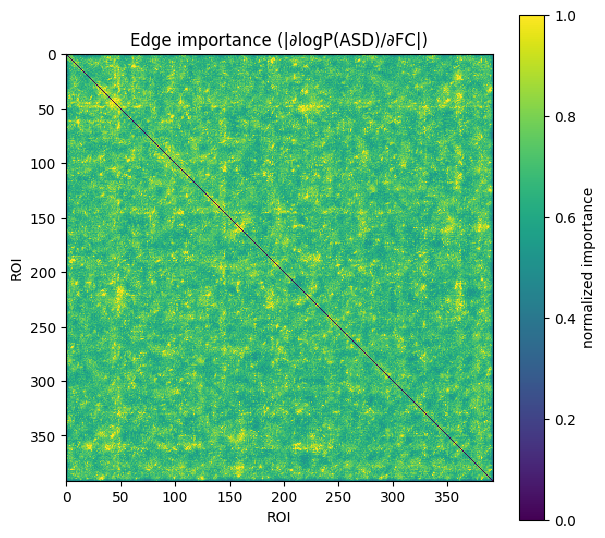

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

CLASS_IDX = 1        
BATCH_SIZE = 16
PERCENTILE_CLIP = 99.5


def _ensure_4d(x):
    """Ensure (N, H, W, 1)."""
    x = np.asarray(x)
    if x.ndim == 3:
        x = x[..., np.newaxis]
    return x

@tf.function
def _batch_gradients(model, xb, class_idx=CLASS_IDX):
    """
    Returns gradients of log-probability of target class wrt inputs.
    More stable than raw probability.
    """
    xb = tf.cast(xb, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(xb)
        probs = model(xb, training=False)                # (B, 2)
        probs = tf.clip_by_value(probs, 1e-7, 1.0)
        logp  = tf.math.log(probs[:, class_idx])         # (B,)
    grads = tape.gradient(logp, xb)                      # (B, H, W, 1)
    return grads

def compute_mean_importance(model, X, batch_size=BATCH_SIZE, class_idx=CLASS_IDX):
    """
    Mean absolute gradient map across subjects. Returns (H, W).
    """
    X = _ensure_4d(X)
    n = X.shape[0]
    acc = None
    for i in range(0, n, batch_size):
        xb = X[i:i+batch_size]
        g  = _batch_gradients(model, xb, class_idx=class_idx).numpy()  # (b, H, W, 1)
        g  = np.abs(g)[..., 0]                                         # (b, H, W)
        if acc is None:
            acc = np.sum(g, axis=0)
        else:
            acc += np.sum(g, axis=0)
    mean_imp = acc / n
    mean_imp = 0.5 * (mean_imp + mean_imp.T)
    np.fill_diagonal(mean_imp, 0.0)
    return mean_imp

def normalize_for_plot(A, pct=PERCENTILE_CLIP):
    vmax = np.percentile(A, pct)
    return np.clip(A / (vmax + 1e-12), 0.0, 1.0)

def plot_importance_heatmap(imp, title="Edge importance (|∂logP(ASD)/∂FC|)"):
    plt.figure(figsize=(6.2, 5.6))
    plt.imshow(imp, aspect='equal', interpolation='nearest')
    plt.colorbar(label='normalized importance')
    plt.title(title)
    plt.xlabel('ROI')
    plt.ylabel('ROI')
    plt.tight_layout()
    plt.show()

model = load_model("fold_2_best.h5")

edge_importance = compute_mean_importance(model, X_val, batch_size=BATCH_SIZE, class_idx=CLASS_IDX)
edge_importance_norm = normalize_for_plot(edge_importance, pct=PERCENTILE_CLIP)

plot_importance_heatmap(edge_importance_norm)

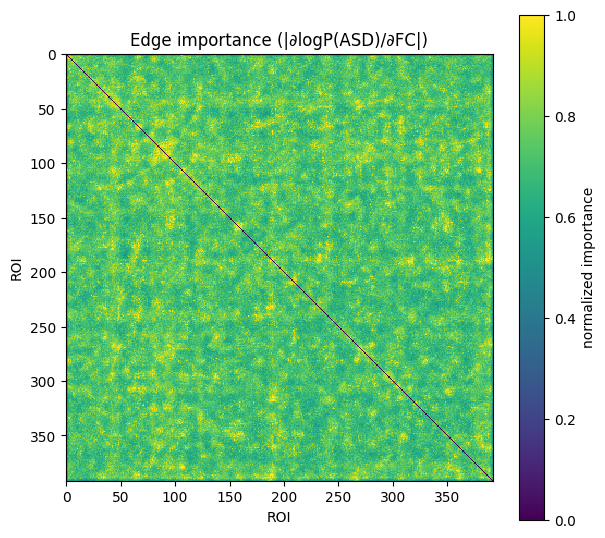

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


CLASS_IDX = 1        
BATCH_SIZE = 16
PERCENTILE_CLIP = 99.5 


def _ensure_4d(x):
    """Ensure (N, H, W, 1)."""
    x = np.asarray(x)
    if x.ndim == 3:
        x = x[..., np.newaxis]
    return x

@tf.function
def _batch_gradients(model, xb, class_idx=CLASS_IDX):
    """
    Returns gradients of log-probability of target class wrt inputs.
    More stable than raw probability.
    """
    xb = tf.cast(xb, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(xb)
        probs = model(xb, training=False)                # (B, 2)
        probs = tf.clip_by_value(probs, 1e-7, 1.0)
        logp  = tf.math.log(probs[:, class_idx])         # (B,)
    grads = tape.gradient(logp, xb)                      # (B, H, W, 1)
    return grads

def compute_mean_importance(model, X, batch_size=BATCH_SIZE, class_idx=CLASS_IDX):
    """
    Mean absolute gradient map across subjects. Returns (H, W).
    """
    X = _ensure_4d(X)
    n = X.shape[0]
    acc = None
    for i in range(0, n, batch_size):
        xb = X[i:i+batch_size]
        g  = _batch_gradients(model, xb, class_idx=class_idx).numpy() 
        g  = np.abs(g)[..., 0]                                         
        if acc is None:
            acc = np.sum(g, axis=0)
        else:
            acc += np.sum(g, axis=0)
    mean_imp = acc / n
 
    mean_imp = 0.5 * (mean_imp + mean_imp.T)
    np.fill_diagonal(mean_imp, 0.0)
    return mean_imp

def normalize_for_plot(A, pct=PERCENTILE_CLIP):
    vmax = np.percentile(A, pct)
    return np.clip(A / (vmax + 1e-12), 0.0, 1.0)

def plot_importance_heatmap(imp, title="Edge importance (|∂logP(ASD)/∂FC|)"):
    plt.figure(figsize=(6.2, 5.6))
    plt.imshow(imp, aspect='equal', interpolation='nearest')
    plt.colorbar(label='normalized importance')
    plt.title(title)
    plt.xlabel('ROI')
    plt.ylabel('ROI')
    plt.tight_layout()
    plt.show()


model = load_model("fold_4_best.h5")

edge_importance = compute_mean_importance(model, X_val, batch_size=BATCH_SIZE, class_idx=CLASS_IDX)
edge_importance_norm = normalize_for_plot(edge_importance, pct=PERCENTILE_CLIP)

plot_importance_heatmap(edge_importance_norm)

In [ ]:
def roi_node_importance(edge_imp):
    """
    Collapse edge importances to ROI/node scores by summing incident edges.
    Returns (H,) node importance.
    """
   
    node_imp = edge_imp.sum(axis=1)
    node_imp = node_imp / (node_imp.max() + 1e-12)
    return node_imp

def top_k_rois(node_imp, k=15, roi_labels=None):
    idx = np.argsort(node_imp)[::-1][:k]
    if roi_labels is None:
        labels = [f"ROI_{i}" for i in idx]
    else:
        labels = [roi_labels[i] for i in idx]
    return list(zip(labels, node_imp[idx], idx))

node_imp = roi_node_importance(edge_importance)
top15 = top_k_rois(node_imp, k=15, roi_labels=None)  
print("Top 15 ROIs by node importance (name, score, index):")
for name, score, idx in top15:
    print(f"{name:>12s}  score={score:.3f}  idx={idx}")

Top 15 ROIs by node importance (name, score, index):
     ROI_189  score=1.000  idx=189
     ROI_388  score=1.000  idx=388
      ROI_42  score=0.988  idx=42
      ROI_95  score=0.987  idx=95
      ROI_97  score=0.983  idx=97
     ROI_387  score=0.976  idx=387
      ROI_44  score=0.976  idx=44
      ROI_43  score=0.973  idx=43
      ROI_92  score=0.971  idx=92
      ROI_81  score=0.969  idx=81
      ROI_93  score=0.968  idx=93
      ROI_94  score=0.964  idx=94
      ROI_45  score=0.963  idx=45
      ROI_83  score=0.963  idx=83
     ROI_386  score=0.963  idx=386


In [ ]:
def top_k_edges(edge_imp, k=2000):
    """
    Return index pairs (i,j) of top-k edges by importance (upper triangle only).
    """
    H = edge_imp.shape[0]
    triu_idx = np.triu_indices(H, k=1)
    vals = edge_imp[triu_idx]
    top_idx = np.argpartition(vals, -k)[-k:]
    ij = (triu_idx[0][top_idx], triu_idx[1][top_idx])
    return list(zip(ij[0], ij[1]))

def knock_out_edges(X, edge_list):
    """
    Zero the listed edges (and symmetric counterparts) in copies of X.
    X: (N, H, W[,1])
    """
    Xn = _ensure_4d(X).copy()
    N, H, W, C = Xn.shape
    for (i, j) in edge_list:
        Xn[:, i, j, 0] = 0.0
        Xn[:, j, i, 0] = 0.0
    return Xn

def mean_asd_prob(model, X, batch_size=BATCH_SIZE, class_idx=CLASS_IDX):
    probs = model.predict(_ensure_4d(X), batch_size=batch_size, verbose=0)
    return float(np.mean(probs[:, class_idx]))

K = 2000
edges_to_zero = top_k_edges(edge_importance, k=K)

p_before = mean_asd_prob(model, X_val)
X_val_knock = knock_out_edges(X_val, edges_to_zero)
p_after  = mean_asd_prob(model, X_val_knock)

print(f"Mean P(ASD) before: {p_before:.4f}")
print(f"Mean P(ASD) after : {p_after:.4f}  (Δ = {p_after - p_before:+.4f})")

Mean P(ASD) before: 0.5005
Mean P(ASD) after : 0.5007  (Δ = +0.0003)


In [ ]:
import numpy as np
import nibabel as nib
from nilearn import image, datasets
from scipy.ndimage import center_of_mass

cc400_nii_path = "/content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset/atlases/CC400.nii" 


cc_img = nib.load(cc400_nii_path)
cc_data = cc_img.get_fdata()
affine = cc_img.affine

roi_values = np.unique(cc_data)
roi_values = roi_values[roi_values > 0] 

# Compute ROI centers (in voxel coords), then convert to MNI coords
def roi_centers_mni(cc_data, affine, roi_vals):
    centers = {}
    for v in roi_vals:
        mask = cc_data == v
        if not np.any(mask):
            continue
        com_vox = center_of_mass(mask)  # voxel-space center
        com_aff = nib.affines.apply_affine(affine, com_vox)  # MNI coords
        centers[int(v)] = np.array(com_aff)
    return centers

roi_centers = roi_centers_mni(cc_data, affine, roi_values)

# Harvard–Oxford cortical atlas (probabilistic)
ho = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr0-2mm')


maps_obj = ho['maps'] if isinstance(ho, dict) or hasattr(ho, '__getitem__') else ho.maps
labels_obj = ho['labels'] if isinstance(ho, dict) or hasattr(ho, '__getitem__') else ho.labels

if isinstance(maps_obj, (str, os.PathLike)):
    ho_img = nib.load(maps_obj)
else:
    ho_img = maps_obj

ho_data = ho_img.get_fdata()

def _decode_label(x):
    try:
        return x.decode('utf-8') if isinstance(x, (bytes, bytearray)) else str(x)
    except Exception:
        return str(x)

ho_labels = [ _decode_label(x) for x in labels_obj ]


def ho_label_at_coord(mni_xyz, ho_img, ho_data, ho_labels):
    ijk = nib.affines.apply_affine(np.linalg.inv(ho_img.affine), mni_xyz)
    ijk = np.round(ijk).astype(int)
    x,y,z = ijk
    if (0 <= x < ho_data.shape[0] and
        0 <= y < ho_data.shape[1] and
        0 <= z < ho_data.shape[2]):
        val = int(ho_data[x,y,z])
        if 0 <= val < len(ho_labels):
            return ho_labels[val]
    return "Unknown/WM/CSF"


idx_to_name = {}
for i in range(392):
    cc_label = i + 1
    mni = roi_centers.get(cc_label, None)
    if mni is None:
        idx_to_name[i] = "Unknown"
    else:
        idx_to_name[i] = ho_label_at_coord(mni, ho_img, ho_data, ho_labels)


top15_idx = [idx for (_, _, idx) in top15]  
for (name, score, idx) in top15:
    print(f"{idx_to_name[idx]:>40s}  score={score:.3f}  idx={idx}")

[fetch_atlas_harvard_oxford] Dataset found in /root/nilearn_data/fsl

                            Frontal Pole  score=1.000  idx=189
                       Postcentral Gyrus  score=1.000  idx=388
                          Occipital Pole  score=0.988  idx=42
                    Middle Frontal Gyrus  score=0.987  idx=95
                              Background  score=0.983  idx=97
                           Temporal Pole  score=0.976  idx=387
Temporal Fusiform Cortex, anterior division  score=0.976  idx=44
                            Frontal Pole  score=0.973  idx=43
                            Frontal Pole  score=0.971  idx=92
                           Planum Polare  score=0.969  idx=81
Middle Temporal Gyrus, temporooccipital part  score=0.968  idx=93
                       Postcentral Gyrus  score=0.964  idx=94
     Heschl's Gyrus (includes H1 and H2)  score=0.963  idx=45
                            Frontal Pole  score=0.963  idx=83
                            Frontal Pole  score=0.963  idx=386


In [133]:
import pandas as pd

rows = []
for (name, score, idx) in top15:
    rows.append({
        "ROI_index": idx,
        "Node_score": float(score),
        "Anatomical_label": idx_to_name.get(idx, name)
    })
top_table = pd.DataFrame(rows).sort_values("Node_score", ascending=False).reset_index(drop=True)
top_table

,ROI_index,Node_score,Anatomical_label
0,189,1.000000,Frontal Pole
1,388,0.999623,Postcentral Gyrus
2,42,0.987509,Occipital Pole
3,95,0.986649,Middle Frontal Gyrus
4,97,0.983335,Background
5,387,0.976458,Temporal Pole
6,44,0.976356,"Temporal Fusiform Cortex, anterior division"
7,43,0.972975,Frontal Pole
8,92,0.971169,Frontal Pole
9,81,0.969052,Planum Polare
